## In this assignment, the goal was to explore ensemble learning techniques and address a research gap identified in the paper:

## ***“A Survey of Ensemble Learning: Concepts, Algorithms, Applications, and Prospects” (IEEE)***

#### The paper provides a comprehensive overview of ensemble learning methods, including bagging, boosting, and stacking. However, it lacks a detailed analysis of hyperparameter tuning and its impact on model performance across different ensemble methods.

#### To fill this gap, implemented ensemble models on the Bank Marketing dataset and performed hyperparameter tuning to analyze performance improvements.

### Notebook Setup imports

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


### load data


* Loads the Bank Marketing dataset.
* sep=';' because the CSV uses semicolons.
* head() shows the first 5 rows to inspect the dataset structure.
* This dataset contains customer information and whether they subscribed to a term deposit (y).


In [2]:
data = pd.read_csv('/kaggle/input/banking/bank-full.csv', sep=';')
print("Dataset shape:", data.shape)
data.head()


Dataset shape: (45211, 17)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Preprocessing

- #### Categorical Encoding: Converts categorical variables into numerical columns (one-hot encoding).

- #### Target Variable: y_yes is the binary target (1 = subscribed, 0 = not subscribed).

- #### Train-test split: 80% training, 20% testing to evaluate model performance.

- #### Feature Scaling: Standardizes features; optional for trees but necessary for Logistic Regression in stacking.

In [3]:
data_encoded = pd.get_dummies(data, drop_first=True)
X = data_encoded.drop('y_yes', axis=1)
y = data_encoded['y_yes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Train Default Ensemble Models

- #### Random Forest: Bagging-based ensemble that reduces variance.

- #### Gradient Boosting: Boosting-based ensemble that reduces bias.

- #### Stacking: Combines multiple base models (RF + GB) and uses Logistic Regression to make final predictions.

- #### This step shows baseline performance before hyperparameter tuning.

In [4]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy (default):", acc_rf)

gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train_scaled, y_train)
y_pred_gb = gb.predict(X_test_scaled)
acc_gb = accuracy_score(y_test, y_pred_gb)
print("Gradient Boosting Accuracy (default):", acc_gb)

estimators = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=100, random_state=42))
]
stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())
stack.fit(X_train_scaled, y_train)
y_pred_stack = stack.predict(X_test_scaled)
acc_stack = accuracy_score(y_test, y_pred_stack)
print("Stacking Accuracy (default):", acc_stack)


Random Forest Accuracy (default): 0.9036824062811014
Gradient Boosting Accuracy (default): 0.9036824062811014
Stacking Accuracy (default): 0.9036824062811014


## Hyperparameter Tuning
- #### GridSearchCV: Systematically tests multiple hyperparameter combinations.

- #### Random Forest tuning: Adjusts number of trees, max depth, and min samples per split.

- #### Gradient Boosting tuning: Adjusts number of trees, learning rate, and depth.

- #### Goal: Improve accuracy by finding the best combination of parameters.

- #### This step directly addresses the research gap in the paper.

In [5]:
# Random Forest tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, n_jobs=-1)
grid_rf.fit(X_train_scaled, y_train)
best_rf = grid_rf.best_estimator_
y_pred_best_rf = best_rf.predict(X_test_scaled)
acc_best_rf = accuracy_score(y_test, y_pred_best_rf)
print("Random Forest Accuracy (tuned):", acc_best_rf)
print("Best RF Parameters:", grid_rf.best_params_)

# Gradient Boosting tuning
param_grid_gb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}
grid_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=3, n_jobs=-1)
grid_gb.fit(X_train_scaled, y_train)
best_gb = grid_gb.best_estimator_
y_pred_best_gb = best_gb.predict(X_test_scaled)
acc_best_gb = accuracy_score(y_test, y_pred_best_gb)
print("Gradient Boosting Accuracy (tuned):", acc_best_gb)
print("Best GB Parameters:", grid_gb.best_params_)


Random Forest Accuracy (tuned): 0.9027977441114674
Best RF Parameters: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 100}
Gradient Boosting Accuracy (tuned): 0.9044564856795311
Best GB Parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}


## Stacking with Tuned Models

- #### Combines tuned RF and GB models in stacking.

- #### Using tuned base models generally improves stacking performance.

- #### Shows the benefit of hyperparameter tuning in ensembles.


In [6]:
estimators_tuned = [
    ('rf', best_rf),
    ('gb', best_gb)
]
stack_tuned = StackingClassifier(estimators=estimators_tuned, final_estimator=LogisticRegression())
stack_tuned.fit(X_train_scaled, y_train)
y_pred_stack_tuned = stack_tuned.predict(X_test_scaled)
acc_stack_tuned = accuracy_score(y_test, y_pred_stack_tuned)
print("Stacking Accuracy (tuned):", acc_stack_tuned)


Stacking Accuracy (tuned): 0.9035718235098972


## Model Evaluation & Visualization

- #### Bar plot to compare model performance visually.

- #### Easy to highlight improvements after tuning.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


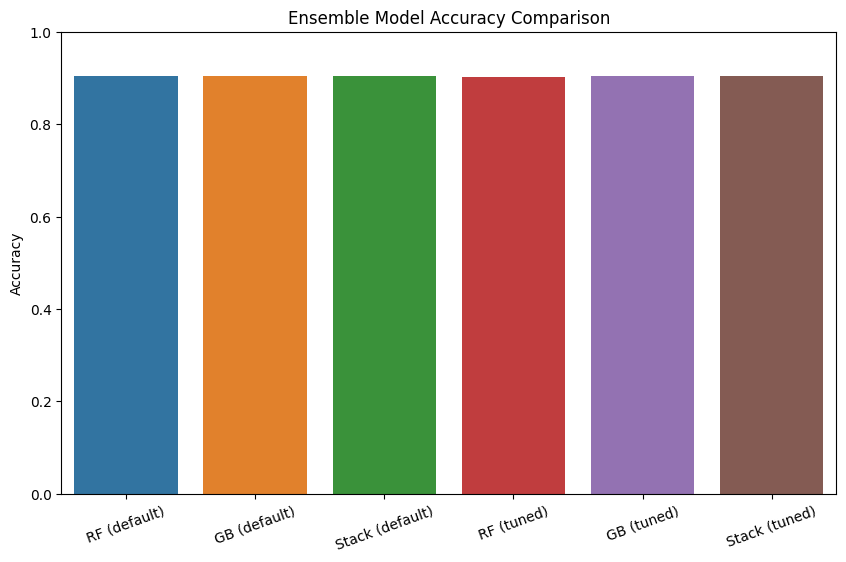

In [7]:
models = ['RF (default)', 'GB (default)', 'Stack (default)', 'RF (tuned)', 'GB (tuned)', 'Stack (tuned)']
accuracies = [acc_rf, acc_gb, acc_stack, acc_best_rf, acc_best_gb, acc_stack_tuned]

plt.figure(figsize=(10,6))
sns.barplot(x=models, y=accuracies)
plt.ylabel('Accuracy')
plt.title('Ensemble Model Accuracy Comparison')
plt.ylim(0,1)
plt.xticks(rotation=20)
plt.show()


- #### Confusion matrix shows true vs predicted labels.

- #### Classification report shows precision, recall, f1-score for each class.

- #### Provides detailed evaluation beyond just accuracy.

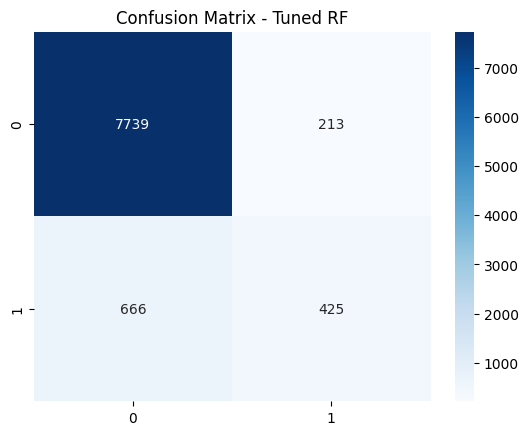

Classification Report - Tuned RF:

              precision    recall  f1-score   support

       False       0.92      0.97      0.95      7952
        True       0.67      0.39      0.49      1091

    accuracy                           0.90      9043
   macro avg       0.79      0.68      0.72      9043
weighted avg       0.89      0.90      0.89      9043



In [8]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best_rf)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned RF")
plt.show()

# Classification report
print("Classification Report - Tuned RF:\n")
print(classification_report(y_test, y_pred_best_rf))


- #### Shows which features contribute most to the model’s prediction.

- #### Useful for reporting insights about the dataset (e.g., duration, pdays).

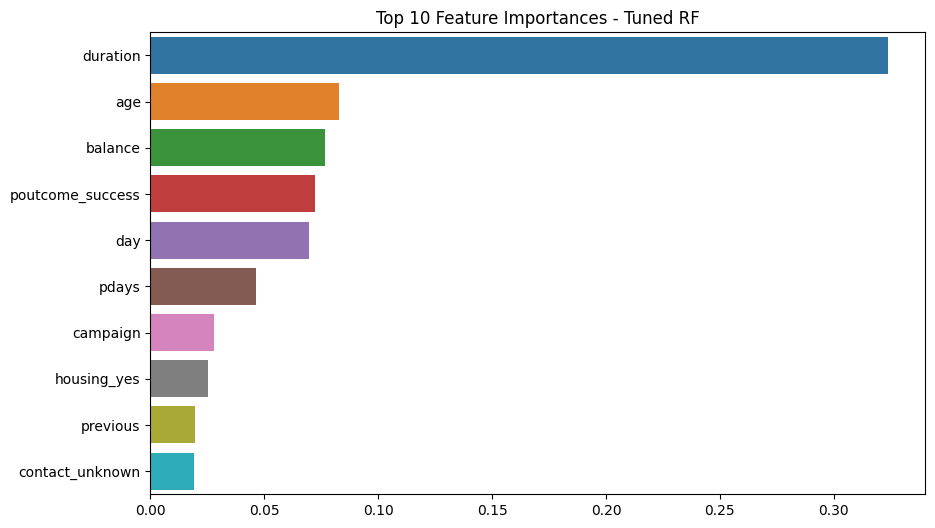

In [9]:
# Feature Importance
importances = best_rf.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values[:10], y=feat_imp.index[:10])
plt.title("Top 10 Feature Importances - Tuned RF")
plt.show()
